In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from mnist_classifier import MNISTClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Define the transformation: resize to 30x30, then convert to tensor, and finally binarize the image
transform = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

# Download the MNIST dataset for training and testing
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [12]:
batch_size = 64

# Prepare the data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [13]:
classifier = MNISTClassifier()

In [14]:
def train_model(model, train_loader, test_loader, optimizer, n_epochs):
    # Assuming the use of CrossEntropyLoss for multi-class classification
    criterion = torch.nn.CrossEntropyLoss()
    
    # Lists to store average losses per epoch
    train_losses = []
    val_losses = []

    # Loop over the dataset multiple times
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        
        # Variables to track progress
        running_loss = 0.0
        total = 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{n_epochs}")
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward and optimize
                loss.backward()
                optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)
                tepoch.set_postfix(loss=running_loss/total)
        
        avg_train_loss = running_loss / total
        train_losses.append(avg_train_loss)
        
        # Validation loss
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_total += inputs.size(0)
                
        avg_val_loss = val_loss / val_total
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses


In [15]:
model = MNISTClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5
train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, n_epochs)

Epoch 1/5: 100%|███████████████| 938/938 [00:19<00:00, 48.77batch/s, loss=0.505]


Epoch 1/5, Train Loss: 0.5049, Validation Loss: 0.1918


Epoch 2/5: 100%|███████████████| 938/938 [00:19<00:00, 47.87batch/s, loss=0.172]


Epoch 2/5, Train Loss: 0.1723, Validation Loss: 0.1472


Epoch 3/5: 100%|███████████████| 938/938 [00:19<00:00, 48.04batch/s, loss=0.127]


Epoch 3/5, Train Loss: 0.1270, Validation Loss: 0.1021


Epoch 4/5: 100%|███████████████| 938/938 [00:19<00:00, 48.50batch/s, loss=0.102]


Epoch 4/5, Train Loss: 0.1022, Validation Loss: 0.0880


Epoch 5/5: 100%|██████████████| 938/938 [00:19<00:00, 48.82batch/s, loss=0.0872]


Epoch 5/5, Train Loss: 0.0872, Validation Loss: 0.0846


In [16]:
model.save_model("mnist_classifier.pth")

Model saved to mnist_classifier.pth


In [20]:
def plot_predictions(model, test_loader, k):
    if k % 4 != 0:
        raise ValueError("k must be a multiple of 4.")
    
    model.eval()  # Set the model to evaluation mode
    images, predictions = [], []

    # Disable gradient calculation for efficiency and to avoid modifying the model
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability
            
            # Store images and predictions
            images.extend(data.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
            
            if len(images) >= k:
                break
    
    # Plotting
    fig, axes = plt.subplots(nrows=k // 4, ncols=4, figsize=(12, (3 * k) // 4))
    for i, ax in enumerate(axes.flat):
        img = images[i].squeeze()  # Remove channel dimension for grayscale image
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {predictions[i][0]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

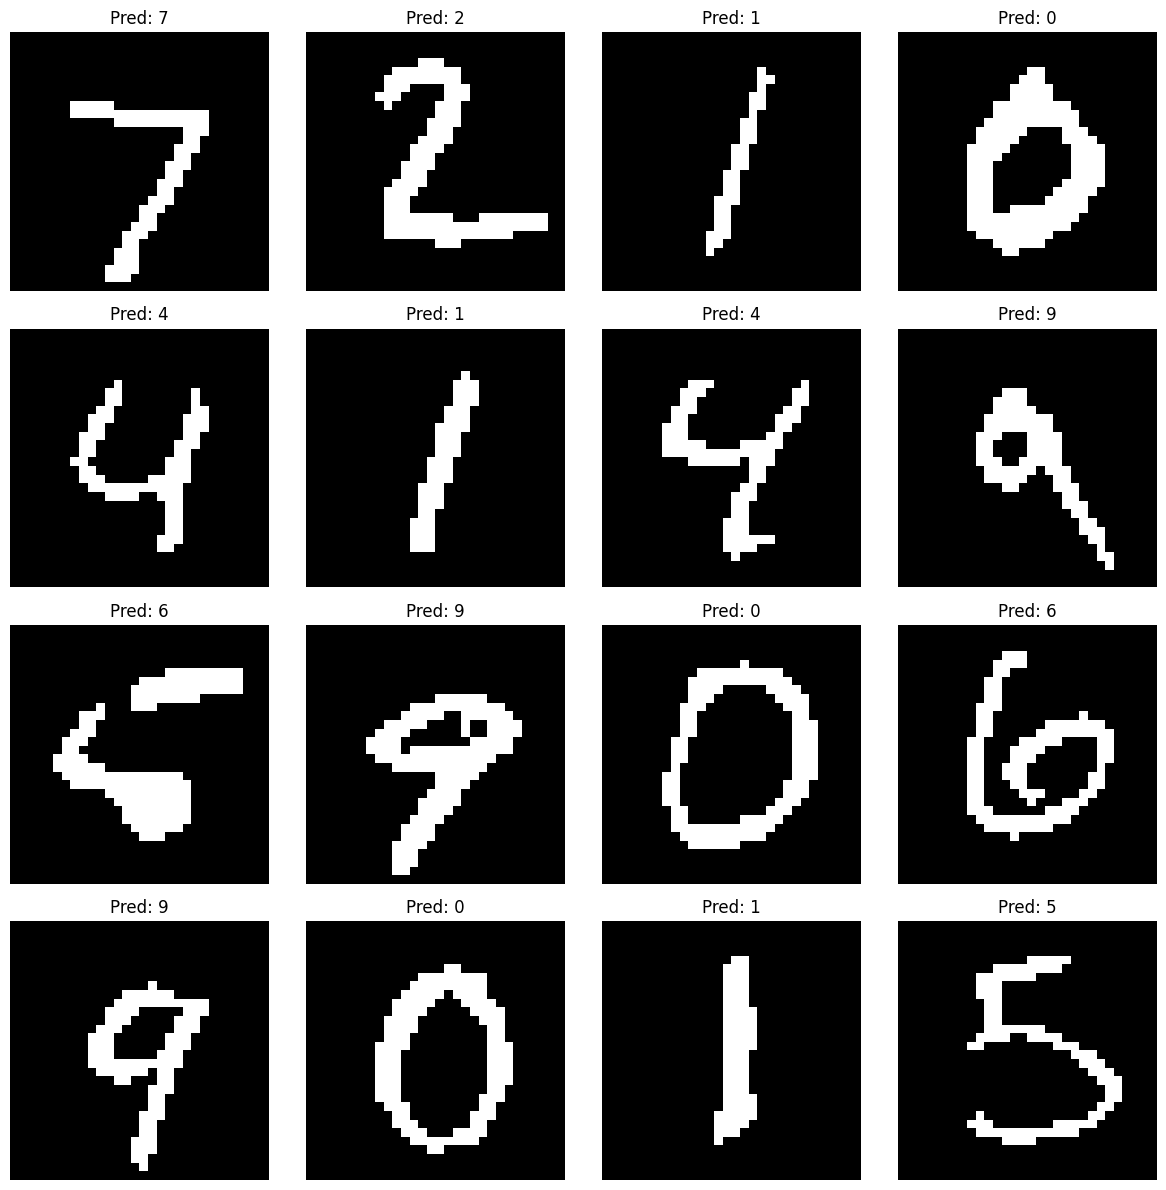

In [22]:
plot_predictions(model, test_loader, 16)